# sgRNA assignment


In this tutorial, we'll be walking through the steps to sgRNA assignment for scCRISPRseq (inc. CROP-seq, Perturb-seq, CRISP-seq) as well as assignment of cell tags for multiplexed indexing experiments. 

In this experiment, A549 lung carcinoma cells were transduced with a pool containing 93 total sgRNAs (90 sgRNAs targeting 45 different genes and 3 control sgRNAs). Cells were split into 6 conditions, receiving no treatment or treatments of DZNep, Trichostatin A, Valproic Acid, Kinetin, or, Resveratrol. Before sequencing, cells were multiplexed at equal proportions with 1 CMO per sample type. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/30-k-a-549-lung-carcinoma-cells-treatments-transduced-with-a-crispr-pool-multiplexed-6-cm-os-3-1-standard-6-0-0), and metadata is available at [../datasets](https://github.com/Novartis/scAR/datasets/)


<div class="alert alert-info">

Note

You need to install [scar](https://scar-tutorials.readthedocs.io/en/latest/) to run this notebook on your own device. 

You can also run it on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/develop/docs/scAR_tutorial_sgRNA_assignment.ipynb)  **This option may not work at the moment**

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scar import model

import warnings
warnings.simplefilter("ignore")

## Download data

The raw count matrices (cellranger output: raw_feature_bc_matrix) can be downloaded from 10x Dataset. Filtered count matrices are not available for this experiment.

In [2]:
A549_30K = sc.read_10x_h5(filename='CRISPR_A549_30K_Multiplex_count_raw_feature_bc_matrix.h5ad',
                          gex_only=False,
                          backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_raw_feature_bc_matrix.h5');

A549_30K.var_names_make_unique();

sgRNA counts (unfiltered droplets)

In [3]:
A549_30K_sgRNA_raw = A549_30K[:, A549_30K.var['feature_types']=='CRISPR Guide Capture'].to_df()

## Estimate ambient profile

Identify cell-containing and cell-free droplets using kneeplot of mRNA counts.

In [4]:
all_droplets = pd.DataFrame(A549_30K[:,A549_30K.var['feature_types']=='Gene Expression'].X.sum(axis=1), index = A549_30K.obs_names, columns=['total_counts'])

all_droplets['droplets'] = 'cell-free droplets'
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>200, 'others')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>500, 'cells')
all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
all_droplets = all_droplets.set_index('index').rename_axis('cells')

<div class="alert alert-info">

Note

The thresholds (200 and 500) are experiment-specific. We currently manually determine them by examing the following kneeplot. 

</div>

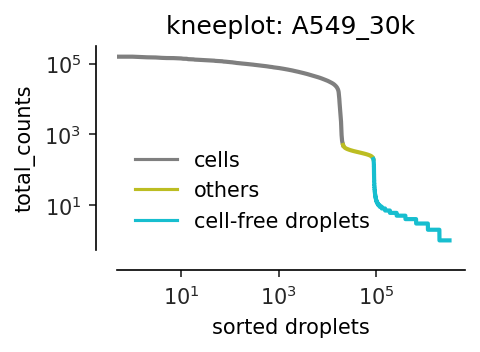

In [5]:
plt.figure(figsize=(3, 1.8), dpi=150)

ax = sns.lineplot(data = all_droplets,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'others', 'cell-free droplets'],
                  palette=sns.color_palette()[-3:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: A549_30k');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

**Raw count matrix of sgRNAs (filtered droplets)**

In [6]:
A549_30K_filtered = A549_30K[A549_30K.obs_names.isin(all_droplets[all_droplets['droplets']=='cells'].index)] # equal to filtered population as cellranger output

In [7]:
A549_30K_sgRNAs_filtered = A549_30K_filtered[:, A549_30K_filtered.var['feature_types']=='CRISPR Guide Capture'].to_df() # pandas.DataFrame

A549_30K_sgRNAs_filtered.head()

,Non-Targeting-5,Non-Targeting-7,Non-Targeting-8,APH1A-1,APH1A-2,CDKN3-1,CDKN3-2,EZR-1,EZR-2,GRB2-1,...,ACE2-1,ACE2-2,TMPRSS2-1,TMPRSS2-2,RAB1A-2,RAB1A-3,DPP4-1,DPP4-2,HDAC1-1,HDAC1-2
AAACCCAAGCTAAGTA-1,0.0,5.0,0.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
AAACCCAAGGAAGTGA-1,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGTTGGAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTGCGTCC-1,1.0,0.0,5.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTGCTCGC-1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Ambient profile of sgRNAs**

In [8]:
cell_free_sgRNAs = A549_30K_sgRNA_raw.loc[A549_30K_sgRNA_raw.index.difference(A549_30K_sgRNAs_filtered.index)]
ambient_profile_sgRNAs = cell_free_sgRNAs.sum()/cell_free_sgRNAs.sum().sum()   # pandas.Series
ambient_profile_sgRNAs = ambient_profile_sgRNAs.to_frame("ambient profile")

ambient_profile_sgRNAs.head()

,ambient profile
Non-Targeting-5,0.022609
Non-Targeting-7,0.026718
Non-Targeting-8,0.035229
APH1A-1,0.022778
APH1A-2,0.003036


## Training

In [9]:
sgRNAs = model(raw_count = A549_30K_sgRNAs_filtered,
               ambient_profile = ambient_profile_sgRNAs, # In the case of default None, the ambient_profile will be calculated by averaging pooled cells
               feature_type = 'sgRNAs')

sgRNAs.train(epochs=100,
             batch_size=64,
             verbose=True
            )

# After training, we can infer the native true signal
sgRNAs.inference(cutoff=3)  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue

..Running VAE using the following param set:
......denoised count type:  sgRNAs
......count model:  binomial
......num_input_feature:  93
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [03:04<00:00,  1.85s/it]
  Inferring .....


Resulting assignment is saved in `sgRNAs.feature_assignment`.

If there are multiple guides detected after denoising, try to increase the cutoff and re-run `sgRNAs.inference(cutoff=10)`

In [10]:
sgRNAs.feature_assignment

,sgRNAs,n_sgRNAs
AAACCCAAGCTAAGTA-1,H2AFY-1,1
AAACCCAAGGAAGTGA-1,PPIB-2,1
AAACCCAAGGTTGGAC-1,ACE2-1,1
AAACCCAAGTGCGTCC-1,Non-Targeting-8,1
AAACCCAAGTGCTCGC-1,CTCF-2,1
...,...,...
TTTGTTGTCCCATTTA-1,CSNK2A1-1,1
TTTGTTGTCGGAACTT-1,EIF4EBP1-2,1
TTTGTTGTCGGCTGTG-1,SUZ12-1,1
TTTGTTGTCTGGGCGT-1,GSK3A-2,1


## Visulization

Plot setting

In [11]:
from matplotlib import pylab

params = {'legend.fontsize': 6,
          'legend.title_fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (4, 3),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'axes.grid':False,}

pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 288x216 with 0 Axes>

### Cell number of sgRNA assignments

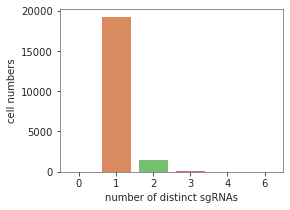

In [12]:
cell_num = sgRNAs.feature_assignment.value_counts("n_sgRNAs").to_frame("cell numbers").reset_index()

plt.figure(figsize=(4, 3))

sns.barplot(data = cell_num,
            x = 'n_sgRNAs',
            y = 'cell numbers'
           );

plt.xlabel("number of distinct sgRNAs");

Most of cells are assigned with a single sgRNA.